# Machine Learning Pipeline for Tweet Classification

This notebook implements a machine learning pipeline for classifying tweets as science-related or not, with two distinct phases of preprocessing.

## Setup

Import required libraries and configure warnings

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, make_scorer
)
import optuna
import emoji
import re
import scipy.sparse
import spacy
from langdetect import detect

## ModelPipeline Class Definition

This class handles all the pipeline operations including preprocessing, model training, and evaluation.

In [3]:
class ModelPipeline:
    def __init__(self, name="ModelPipeline"):
        self.name = name
        self.models = {
            "Naïve Bayes": MultinomialNB(),
            "Random Forest": RandomForestClassifier(n_jobs=-1),
            "SVM": SVC(kernel='linear'),
            "KNN": KNeighborsClassifier(n_jobs=-1),
            "AdaBoost": AdaBoostClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
            "Neural Network - MLP": MLPClassifier(max_iter=300)
        }
        self.scorers = {
            "Accuracy": make_scorer(accuracy_score),
            "Precision": make_scorer(precision_score, average='weighted'),
            "Recall": make_scorer(recall_score, average='weighted'),
            "F1 Score": make_scorer(f1_score, average='weighted')
        }
        self.results = {}

    def preprocess_data(self, df, with_preprocessing=False):
        """Preprocess data based on the phase (with or without preprocessing)"""
        # Convert emojis
        df['text'] = df['text'].apply(lambda x: emoji.demojize(x))
        
        # Add binary features
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')
        
        if with_preprocessing:
            # Advanced preprocessing for Phase 2
            try:
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            except OSError:
                print("Installing spaCy models...")
                import os
                os.system("python -m spacy download fr_core_news_sm")
                os.system("python -m spacy download en_core_web_sm")
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            
            def clean_and_lemmatize_multilang(text):
                text = text.lower()
                text = re.sub(r"http\S+", "URL", text)
                text = re.sub(r"@\w+", "MENTION", text)
                text = re.sub(r"#(\w+)", r"\1", text)
                text = re.sub(r"[^\w\s:]", "", text)
                try:
                    lang = detect(text)
                except:
                    lang = "en"
                doc = nlp_fr(text) if lang == "fr" else nlp_en(text)
                return " ".join([token.lemma_ for token in doc if not token.is_stop])
            
            df['text_clean'] = df['text'].apply(clean_and_lemmatize_multilang)
            text_column = 'text_clean'
        else:
            text_column = 'text'

        return df, text_column

    def prepare_features(self, df, text_column, stopwords=None, max_features=10000):
        """Prepare feature matrix from preprocessed data with feature limitation"""
        vectorizer = TfidfVectorizer(
            min_df=5,
            max_df=0.95,
            stop_words=stopwords,
            lowercase=True,
            ngram_range=(1, 2),
            max_features=max_features
        ) if stopwords else TfidfVectorizer(max_features=max_features)
        
        X_text = df[text_column]
        X_tfidf = vectorizer.fit_transform(X_text)
        
        # Binary features
        extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
        X_extra = scipy.sparse.csr_matrix(extra_features.values)
        
        # Combine features
        X_final = scipy.sparse.hstack([X_tfidf, X_extra])
        
        return X_final, vectorizer

    def train_and_evaluate(self, X, y, phase_name):
        """Train and evaluate models using k-fold cross-validation"""
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = []
        
        for name, model in self.models.items():
            print(f"\n🔍 Training model: {name}")
            
            # Store metrics for each fold
            fold_metrics = {
                "Accuracy": [],
                "Precision": [],
                "Recall": [],
                "F1": []
            }
            
            # Iterate through folds
            for fold, (train_idx, test_idx) in enumerate(cv.split(X.toarray() if scipy.sparse.issparse(X) else X, y), 1):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Calculate and store metrics for this fold
                fold_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
                fold_metrics["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
                fold_metrics["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
                fold_metrics["F1"].append(f1_score(y_test, y_pred, average='weighted'))
                
                # Plot confusion matrix for last fold
                if fold == cv.n_splits:
                    plt.figure(figsize=(6, 5))
                    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
                    plt.title(f'Confusion Matrix - {name} ({phase_name})')
                    plt.xlabel('Predicted')
                    plt.ylabel('True')
                    plt.show()
            
            # Calculate mean and std of metrics across folds
            metrics = {
                "Model": name,
                "Phase": phase_name
            }
            
            for metric_name, scores in fold_metrics.items():
                metrics[metric_name] = np.mean(scores)
                metrics[f"{metric_name}_Std"] = np.std(scores)
                print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            
            results.append(metrics)
        
        # Save results to CSV
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'model_results_{phase_name.lower().replace(" ", "_")}.csv', index=False)
        return results_df

## Data Loading

Load and prepare the dataset for processing

In [4]:
# Load data
print("Loading data...")
df = pd.read_csv('scitweets_balanced.tsv', sep='\t')
df.dropna(subset=['text'], inplace=True)
y = df['science_related']

# Display sample of the data
print("\nSample of the dataset:")
display(df.head())

# Initialize pipeline
pipeline = ModelPipeline()

Loading data...

Sample of the dataset:


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0.0,3.166700e+17,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1.0,3.190909e+17,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2.0,3.220309e+17,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3.0,3.226948e+17,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4.0,3.285244e+17,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


## Phase 1: Without Preprocessing

Process and evaluate models using basic preprocessing

=== Phase 1: Without Preprocessing ===

🔍 Training model: Naïve Bayes


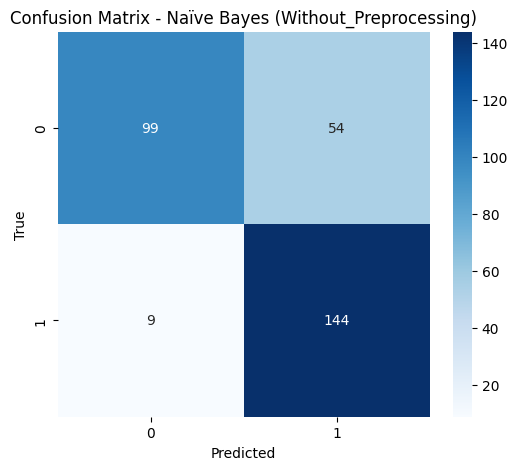

Accuracy: 0.7987 ± 0.0123
Precision: 0.8296 ± 0.0129
Recall: 0.7987 ± 0.0123
F1: 0.7938 ± 0.0128

🔍 Training model: Random Forest


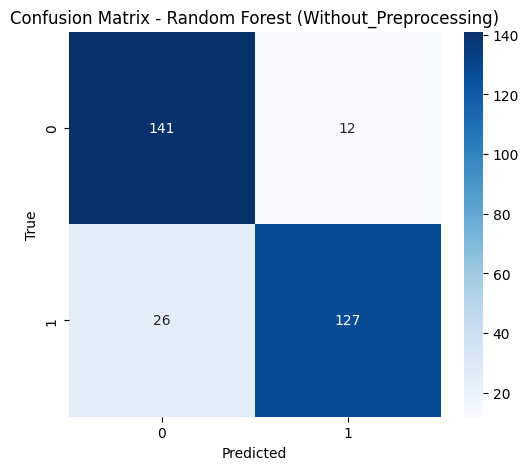

Accuracy: 0.8941 ± 0.0169
Precision: 0.8969 ± 0.0158
Recall: 0.8941 ± 0.0169
F1: 0.8939 ± 0.0170

🔍 Training model: SVM


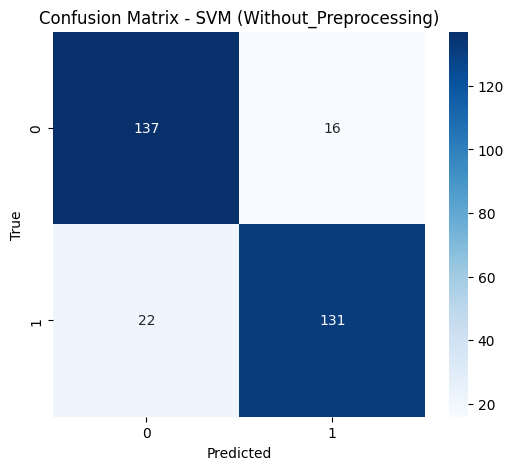

Accuracy: 0.9013 ± 0.0139
Precision: 0.9017 ± 0.0138
Recall: 0.9013 ± 0.0139
F1: 0.9013 ± 0.0139

🔍 Training model: KNN


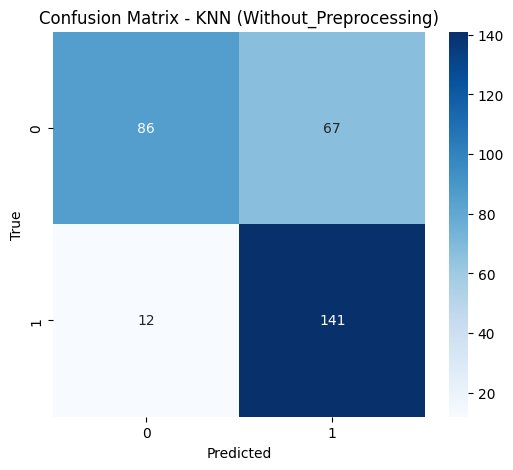

Accuracy: 0.7497 ± 0.0105
Precision: 0.7743 ± 0.0095
Recall: 0.7497 ± 0.0105
F1: 0.7439 ± 0.0116

🔍 Training model: AdaBoost


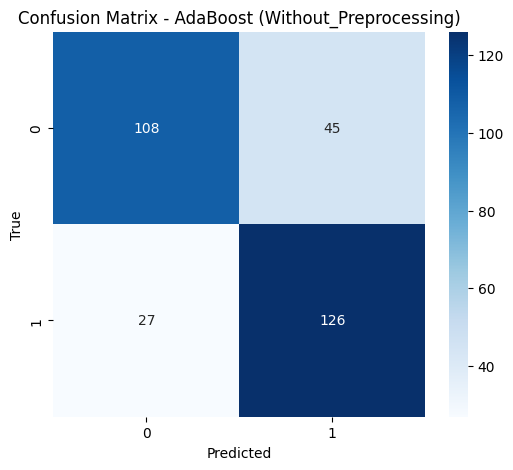

Accuracy: 0.7595 ± 0.0223
Precision: 0.7636 ± 0.0190
Recall: 0.7595 ± 0.0223
F1: 0.7584 ± 0.0233

🔍 Training model: XGBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:42:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_en

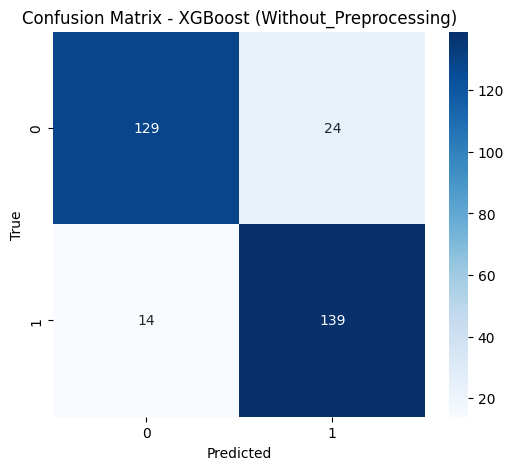

Accuracy: 0.8680 ± 0.0285
Precision: 0.8688 ± 0.0288
Recall: 0.8680 ± 0.0285
F1: 0.8679 ± 0.0285

🔍 Training model: Neural Network - MLP


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


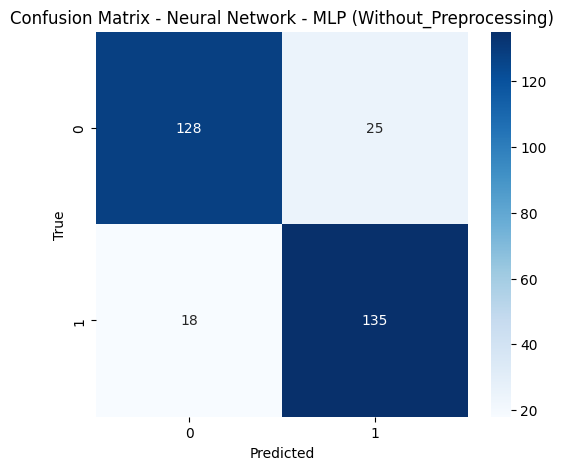

Accuracy: 0.9013 ± 0.0221
Precision: 0.9017 ± 0.0219
Recall: 0.9013 ± 0.0221
F1: 0.9013 ± 0.0221

Phase 1 Results:


,Model,Phase,Accuracy,Accuracy_Std,Precision,Precision_Std,Recall,Recall_Std,F1,F1_Std
0,Naïve Bayes,Without_Preprocessing,0.798693,0.012332,0.829591,0.012906,0.798693,0.012332,0.793849,0.012786
1,Random Forest,Without_Preprocessing,0.894118,0.016867,0.896943,0.015781,0.894118,0.016867,0.893912,0.016985
2,SVM,Without_Preprocessing,0.901307,0.013926,0.901683,0.013805,0.901307,0.013926,0.901283,0.013939
3,KNN,Without_Preprocessing,0.749673,0.010458,0.774291,0.009530,0.749673,0.010458,0.743888,0.011609
4,AdaBoost,Without_Preprocessing,0.759477,0.022318,0.763649,0.018979,0.759477,0.022318,0.758379,0.023308
5,XGBoost,Without_Preprocessing,0.867974,0.028534,0.868820,0.028822,0.867974,0.028534,0.867905,0.028519
6,Neural Network - MLP,Without_Preprocessing,0.901307,0.022107,0.901724,0.021925,0.901307,0.022107,0.901278,0.022129


In [5]:
print("=== Phase 1: Without Preprocessing ===")
df_phase1, text_column = pipeline.preprocess_data(df.copy(), with_preprocessing=False)
X_phase1, _ = pipeline.prepare_features(df_phase1, text_column)
results_phase1 = pipeline.train_and_evaluate(X_phase1, y, "Without_Preprocessing")

# Display results
print("\nPhase 1 Results:")
display(results_phase1)

## Phase 2: With Preprocessing

Process and evaluate models using advanced preprocessing techniques

In [ ]:
print("=== Phase 2: With Preprocessing ===")
df_phase2, text_column = pipeline.preprocess_data(df.copy(), with_preprocessing=True)

# Load French stopwords
stopwords_df = pd.read_csv("StopWordsFrench.csv", sep=',', index_col=0)
french_stopwords = stopwords_df.index.tolist()

X_phase2, _ = pipeline.prepare_features(df_phase2, text_column, french_stopwords)
results_phase2 = pipeline.train_and_evaluate(X_phase2, y, "With_Preprocessing")

# Display results
print("\nPhase 2 Results:")
display(results_phase2)

## Results Comparison

Compare the results between both phases

In [ ]:
# Combine results
all_results = pd.concat([results_phase1, results_phase2])

# Plot comparison
plt.figure(figsize=(15, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=all_results, x='Phase', y=metric, hue='Model')
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    if i > 1:  # Only show legend for the first subplot
        plt.legend([])
    
plt.tight_layout()
plt.show()